In [1]:
import gpytorch

import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import random
import os


In [2]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def split_dataset_for_multilabel(X, multi_y, test_size=0.15, val_size=0.25, random_state=42, num_classes=6):
    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(X, multi_y))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = multi_y[train_idx], multi_y[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X_train, y_train))

        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X, multi_y))

        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = multi_y[train_idx], multi_y[val_idx]
        X_test, y_test = None, None

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test

from sklearn.model_selection import StratifiedShuffleSplit
def split_data(X, y, test_size=0.15, val_size=0.15, random_state=42):
    if test_size > 0:
        # First split: train + test
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(sss.split(X, y[:, 0]))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Second split: train + validation
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X_train, y_train[:, 0]))

        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]
    else:
        # Only split into train and validation if test_size is 0
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X, y[:, 0]))

        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = y[train_idx], y[val_idx]
        X_test, y_test = None, None

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test

In [3]:
# from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
# from sklearn.model_selection import StratifiedShuffleSplit
# import numpy as np
#
# def split_dataset_for_multilabel(X, multi_y, test_size=0.15, val_size=0.15, random_state=42, num_classes=6):
#     if num_classes > 1:
#         stratifier = MultilabelStratifiedShuffleSplit
#         y_for_split = multi_y
#     else:
#         stratifier = StratifiedShuffleSplit
#         y_for_split = multi_y[:, 0]  # Use only the first column for binary classification
#
#     if test_size > 0:
#         # First split: train + test
#         sss = stratifier(n_splits=1, test_size=test_size, random_state=random_state)
#         train_idx, test_idx = next(sss.split(X, y_for_split))
#
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = multi_y[train_idx], multi_y[test_idx]
#
#         # Second split: train + validation
#         sss_val = stratifier(n_splits=1, test_size=val_size, random_state=random_state)
#         train_idx, val_idx = next(sss_val.split(X_train, y_train if num_classes > 1 else y_train[:, 0]))
#
#         X_train_final, X_val = X_train[train_idx], X_train[val_idx]
#         y_train_final, y_val = y_train[train_idx], y_train[val_idx]
#
#     else:
#         # Only split into train and validation if test_size is 0
#         sss_val = stratifier(n_splits=1, test_size=val_size, random_state=random_state)
#         train_idx, val_idx = next(sss_val.split(X, y_for_split))
#
#         X_train_final, X_val = X[train_idx], X[val_idx]
#         y_train_final, y_val = multi_y[train_idx], multi_y[val_idx]
#         X_test, y_test = None, None
#
#     return X_train_final, y_train_final, X_val, y_val, X_test, y_test


# Seed Everything

# Attention

In [4]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))

        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

class MILAttentionLayer(nn.Module):
    """Implementation of the attention-based Deep MIL layer."""

    def __init__(
        self,
        input_dim,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
    ):
        super().__init__()

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        # Initialize weights
        self.v_weight_params = nn.Parameter(torch.Tensor(input_dim, weight_params_dim))
        self.w_weight_params = nn.Parameter(torch.Tensor(weight_params_dim, 1))

        if self.use_gated:
            self.u_weight_params = nn.Parameter(torch.Tensor(input_dim, weight_params_dim))

        # Initialize weights using the specified initializer
        if kernel_initializer == "glorot_uniform":
            nn.init.xavier_uniform_(self.v_weight_params)
            nn.init.xavier_uniform_(self.w_weight_params)
            if self.use_gated:
                nn.init.xavier_uniform_(self.u_weight_params)

        # Add regularization if specified
        self.kernel_regularizer = kernel_regularizer

    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = torch.tanh(torch.matmul(instance, self.v_weight_params))

        if self.use_gated:
            instance = instance * torch.sigmoid(torch.matmul(original_instance, self.u_weight_params))

        return torch.matmul(instance, self.w_weight_params)

    def forward(self, x):
        attention_scores = self.compute_attention_scores(x)
        attention_weights = torch.softmax(attention_scores, dim=1)
        return torch.sum(x * attention_weights, dim=1)

    def regularization_loss(self):
        reg_loss = 0
        if self.kernel_regularizer:
            reg_loss += self.kernel_regularizer(self.v_weight_params)
            reg_loss += self.kernel_regularizer(self.w_weight_params)
            if self.use_gated:
                reg_loss += self.kernel_regularizer(self.u_weight_params)
        return reg_loss

# Model

In [5]:
threshold = 0.5
from layers.gaussian_process import PGLikelihood, SingletaskGPModel

# Define the CNN_Att Model
class CNN_Att(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, Xtrain, BagLabels, num_ind=50, verbose=False):
        super(CNN_Att, self).__init__()

        self.dropout = nn.Dropout(0.25)
        self.gp_layer = nn.ModuleList([SingletaskGPModel(torch.rand(num_ind, 1)) for _ in range(NUM_CLASSES)])

        self.fc = nn.Linear(feature_dim + 1, 1)  # Fully connected layer
        self.attention_layer = nn.ModuleList([AttentionLayer(feature_dim, hidden_dim) for _ in range(NUM_CLASSES)])
        self.att_layer = nn.ModuleList([MILAttentionLayer(feature_dim, hidden_dim) for _ in range(NUM_CLASSES)])
        self.fc_gp = nn.Linear(feature_dim, 1)

    def forward(self, x):
        output = []
        gp_output = []
        for i in range(NUM_CLASSES):
            attended_features = self.att_layer[i](x)
            attended_features = self.dropout(attended_features)
            gp = self.gp_layer[i](self.fc_gp(attended_features))
            gp_output.append(gp)
            combine_feature = torch.cat([attended_features, gp.mean.unsqueeze(-1)], dim=-1)
            combine_feature = self.fc(combine_feature)
            output.append(combine_feature)
        output = torch.cat(output, dim=-1)

        return output, gp_output, _

# Dataset and DataLoader

In [6]:
# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, multi_labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        # self.labels = torch.tensor(labels, dtype=torch.float32)
        self.multi_labels = torch.tensor(multi_labels, dtype=torch.float32)
        print(f'shape of multi_labels: {self.multi_labels.shape}')
        self.labels = self.multi_labels[:, 0]

    def __len__(self):
        return len(self.multi_labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.multi_labels[idx]
# Training function

def load_data(csv_file, num_instances=57, test_size=0.2, random_state=42, dataset='rsna'):
    df = pd.read_csv(csv_file)

    # Group features by bag_name
    grouped = df.groupby('bag_name')
    # grouped = df.groupby('bag_id')

    # Prepare feature lists and label lists
    feature_list = []
    bag_label_list = []
    multi_label_list = []
    if dataset == 'cq500':
        multi_label_names = ['patient_ICH', 'patient_EDH', 'patient_IPH', 'patient_IVH', 'patient_SAH', 'patient_SDH']
    else:
        multi_label_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    # multi_label_names =['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']

    for bag_name, group in grouped:
        # Extract features for the current bag
        feature_cols = [f'feature_{i}' for i in range(8)]
        features = group[feature_cols].values

        # Pad with zeros if the number of instances is less than num_instances
        if len(features) < num_instances:
            padding_size = num_instances - len(features)
            padding = np.zeros((padding_size, 8))
            features = np.vstack((features, padding))  # Vertically stack features and padding

        # Truncate if the number of instances is greater than num_instances
        elif len(features) > num_instances:
            features = features[:num_instances]

        feature_list.append(features)

        # Get the bag label for the current bag
        bag_label = group['bag_label'].values[0]
        # bag_label = group['patient_label'].values[0]
        bag_label_list.append(bag_label)

        # Process multi-labels
        multi_labels = []
        for label in multi_label_names:
            # If any instance in the bag has the label, set it to 1
            label_value = 1 if (group[label] == 1).any() else 0
            multi_labels.append(label_value)
        multi_label_list.append(multi_labels)

    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(bag_label_list)
    multi_y = np.array(multi_label_list)

    return X, y, multi_y

# Metrics

In [7]:
# def calculate_metrics(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#
#     # We calculate the partial accuracy, precision, recall, f1 for each class separately
#     partial_accuracy = []
#     precision = []
#     recall = []
#     f1 = []
#     for i in range(NUM_CLASSES):
#         # Calculate partial accuracy
#         correct = (y_true[:, i] == y_pred[:, i]).sum()
#         total = len(y_true)
#         partial_accuracy.append(correct / total)
#
#         # Calculate precision
#         tp = ((y_true[:, i] == 1) & (y_pred[:, i] == 1)).sum()
#         fp = ((y_true[:, i] == 0) & (y_pred[:, i] == 1)).sum()
#         precision.append(tp / (tp + fp) if tp + fp > 0 else 0)
#
#         # Calculate recall
#         fn = ((y_true[:, i] == 1) & (y_pred[:, i] == 0)).sum()
#         recall.append(tp / (tp + fn) if tp + fn > 0 else 0)
#
#         # Calculate F1 score
#         f1.append(2 * tp / (2 * tp + fp + fn) if 2 * tp + fp + fn > 0 else 0)
#
#     # Return mean values for all metrics
#     metrics = {
#         'partial_accuracy': np.mean(partial_accuracy),
#         'precision': np.mean(precision),
#         'recall': np.mean(recall),
#         'f1': np.mean(f1)
#     }
#
#     return metrics

def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_micro = np.sum(2 * tp) / (np.sum(2 * tp) + np.sum(fp + fn))

    metrics = {
        'partial_accuracy': np.mean((y_true == y_pred).mean(axis=0)),
        'precision_macro': np.nanmean(precision),
        'recall_macro': np.nanmean(recall),
        'f1_macro': np.nanmean(f1),
        'precision_micro': np.sum(tp) / (np.sum(tp) + np.sum(fp)),
        'recall_micro': np.sum(tp) / (np.sum(tp) + np.sum(fn)),
        'f1_micro': f1_micro
    }
    return metrics


# Training function

In [8]:
def train(model, dataloader, optimizer, criterion, device, likelihood, var_optimizer, mlls):
    model.train()
    likelihood.train()
    epoch_loss = 0
    all_labels = []
    all_preds = []
    with gpytorch.settings.num_likelihood_samples(100):
        for features, labels, multi_labels in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            optimizer.zero_grad()
            for i in range(NUM_CLASSES):
                var_optimizer[i].zero_grad()

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)
            loss = 0
            for i in range(NUM_CLASSES):
                loss += -mlls[i](gp_output[i], multi_labels[:, i])
            loss = loss.mean()
            if NUM_CLASSES == 1:
                loss = loss * 0.5 + criterion(predictions.squeeze(-1), multi_labels[:, 0]) * 0.5
            else:
                loss = loss * 0.5 + criterion(predictions, multi_labels) * 0.5
            loss = loss.mean()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            for i in range(NUM_CLASSES):
                var_optimizer[i].step()

            epoch_loss += loss.item()

            probs = [likelihood[i](gp_output[i]).probs for i in range(NUM_CLASSES)]
            # probs = [torch.sigmoid(predictions[:, i]) for i in range(NUM_CLASSES)]
            probs = torch.stack(probs, dim=-1)
            preds = probs.ge(threshold).float()

            all_preds.extend(preds.cpu().numpy())
            if NUM_CLASSES == 1:
                all_labels.extend(labels.cpu().numpy())
            else:
                all_labels.extend(multi_labels.cpu().numpy())

    metrics = calculate_metrics(all_labels, all_preds)
    print(f'Partial accuracy: {metrics["partial_accuracy"]:.4f}, Precision: {metrics["precision_macro"]:.4f}, Recall: {metrics["recall_macro"]:.4f}, F1: {metrics["f1_macro"]:.4f}')
    print(f'Precision (micro): {metrics["precision_micro"]:.4f}, Recall (micro): {metrics["recall_micro"]:.4f}, F1 (micro): {metrics["f1_micro"]:.4f}')

    return epoch_loss / len(dataloader), metrics['partial_accuracy'], metrics['precision_micro'], metrics['recall_micro'], metrics['f1_micro']

# Evaluation function
def evaluate(model, dataloader, criterion, device, likelihood, mlls):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for features, labels, multi_labels in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)

            loss = 0
            for i in range(NUM_CLASSES):
                loss += -mlls[i](gp_output[i], multi_labels[:, i])
            loss = loss / NUM_CLASSES
            if NUM_CLASSES == 1:
                loss = loss * 0.5 + criterion(predictions.squeeze(-1), multi_labels[:, 0]) * 0.5
            else:
                loss = loss * 0.5 + criterion(predictions, multi_labels) * 0.5
            loss = loss.mean()

            epoch_loss += loss.item()

            probs = [likelihood[i](gp_output[i]).probs for i in range(NUM_CLASSES)]
            # probs = [torch.sigmoid(predictions[:, i]) for i in range(NUM_CLASSES)]
            probs = torch.stack(probs, dim=-1)
            if NUM_CLASSES == 1:
                all_labels.extend(labels.cpu().numpy())
            else:
                all_labels.extend(multi_labels.cpu().numpy())

            all_preds.extend((probs >= threshold).cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

    # accuracy = accuracy_score(all_labels, all_preds)
    # if NUM_CLASSES == 1:
    #     average = 'binary'
    # else:
    #     average = 'samples'
    # precision = precision_score(all_labels, all_preds, average=average)
    # recall = recall_score(all_labels, all_preds, average=average)
    # f1 = f1_score(all_labels, all_preds, average=average)
    # if NUM_CLASSES == 1:
    #     cohen_kappa = cohen_kappa_score(all_labels, all_preds)
    # else:
    #     cohen_kappa = 0
    metrics = calculate_metrics(all_labels, all_preds)
    accuracy = metrics['partial_accuracy']
    precision = metrics['precision_micro']
    recall = metrics['recall_micro']
    f1 = metrics['f1_micro']
    cohen_kappa = 0
    return epoch_loss / len(dataloader), accuracy, precision, recall, f1, cohen_kappa, all_labels, all_scores

# Visualization

In [9]:
def plot_roc_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc

def plot_pr_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    return auc_pr

def plot_confusion_matrix(y_true, y_scores):
    y_pred = []
    for score in y_scores:
        if score >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc_multilabel(y_true, y_scores, class_names):
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-label')
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve_multilabel(y_true, y_scores, class_names):
    n_classes = y_scores.shape[1]

    # Compute Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    # Plot Precision-Recall curves
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'{class_names[i]} (AUC = {average_precision[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Multi-label')
    plt.legend(loc="lower left")
    plt.show()

def plot_confusion_matrix_multilabel(y_true, y_pred, class_names):
    n_classes = y_true.shape[1]

    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    axes = axes.ravel()

    for i in range(n_classes):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].set_title(f'Confusion Matrix - {class_names[i]}')

    plt.tight_layout()
    plt.show()


# Main function

shape of multi_labels: torch.Size([750, 6])
shape of multi_labels: torch.Size([250, 6])
shape of multi_labels: torch.Size([150, 6])
Starting training...
Partial accuracy: 0.8071, Precision: 0.2503, Recall: 0.0734, F1: 0.1234
Precision (micro): 0.5108, Recall (micro): 0.1352, F1 (micro): 0.2138
Epoch 1/100: Train: Loss=0.5804, Acc=0.8071, Precision=0.5108, Recall=0.1352, F1=0.2138
Validation: Loss=0.5918, Acc=0.8293, Precision=1.0000, Recall=0.1322, F1=0.2335

Partial accuracy: 0.8196, Precision: 0.6763, Recall: 0.0644, F1: 0.4916
Precision (micro): 0.6763, Recall (micro): 0.1340, F1 (micro): 0.2237
Epoch 2/100: Train: Loss=0.2360, Acc=0.8196, Precision=0.6763, Recall=0.1340, F1=0.2237
Validation: Loss=0.4868, Acc=0.8380, Precision=1.0000, Recall=0.1763, F1=0.2997

Partial accuracy: 0.8191, Precision: 0.6372, Recall: 0.0754, F1: 0.5290
Precision (micro): 0.6372, Recall (micro): 0.1569, F1 (micro): 0.2518
Epoch 3/100: Train: Loss=0.0933, Acc=0.8191, Precision=0.6372, Recall=0.1569, F1=0.

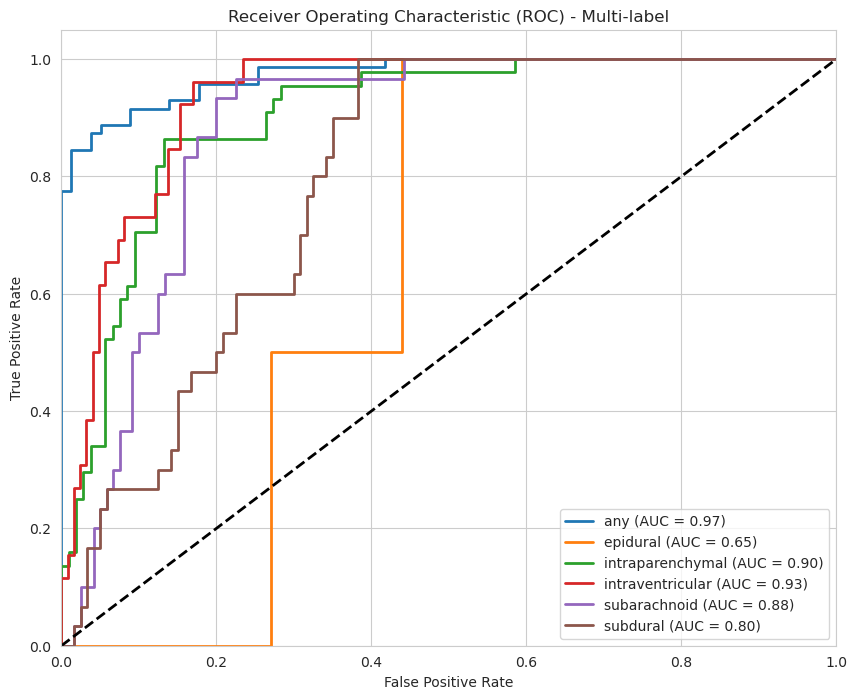

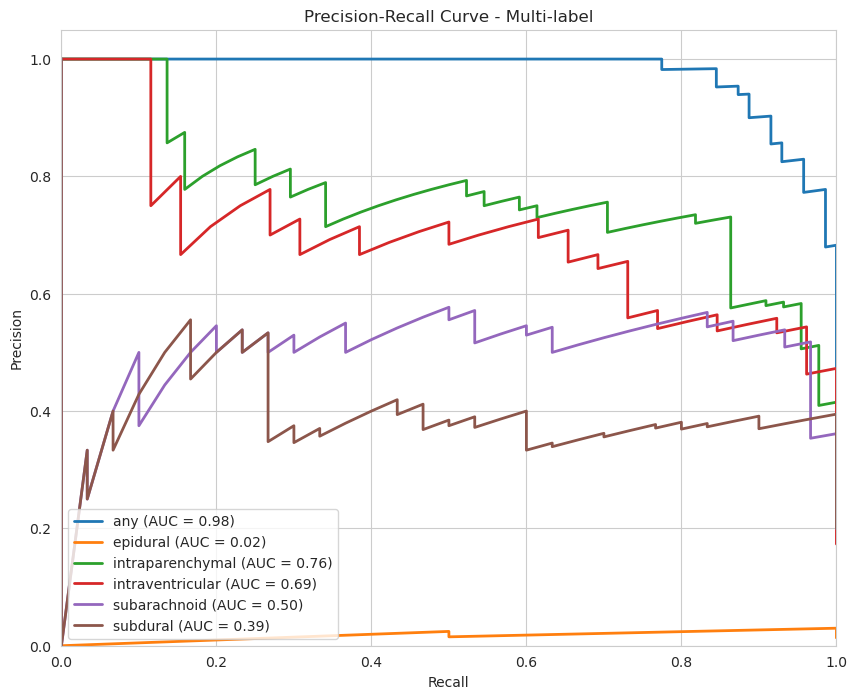

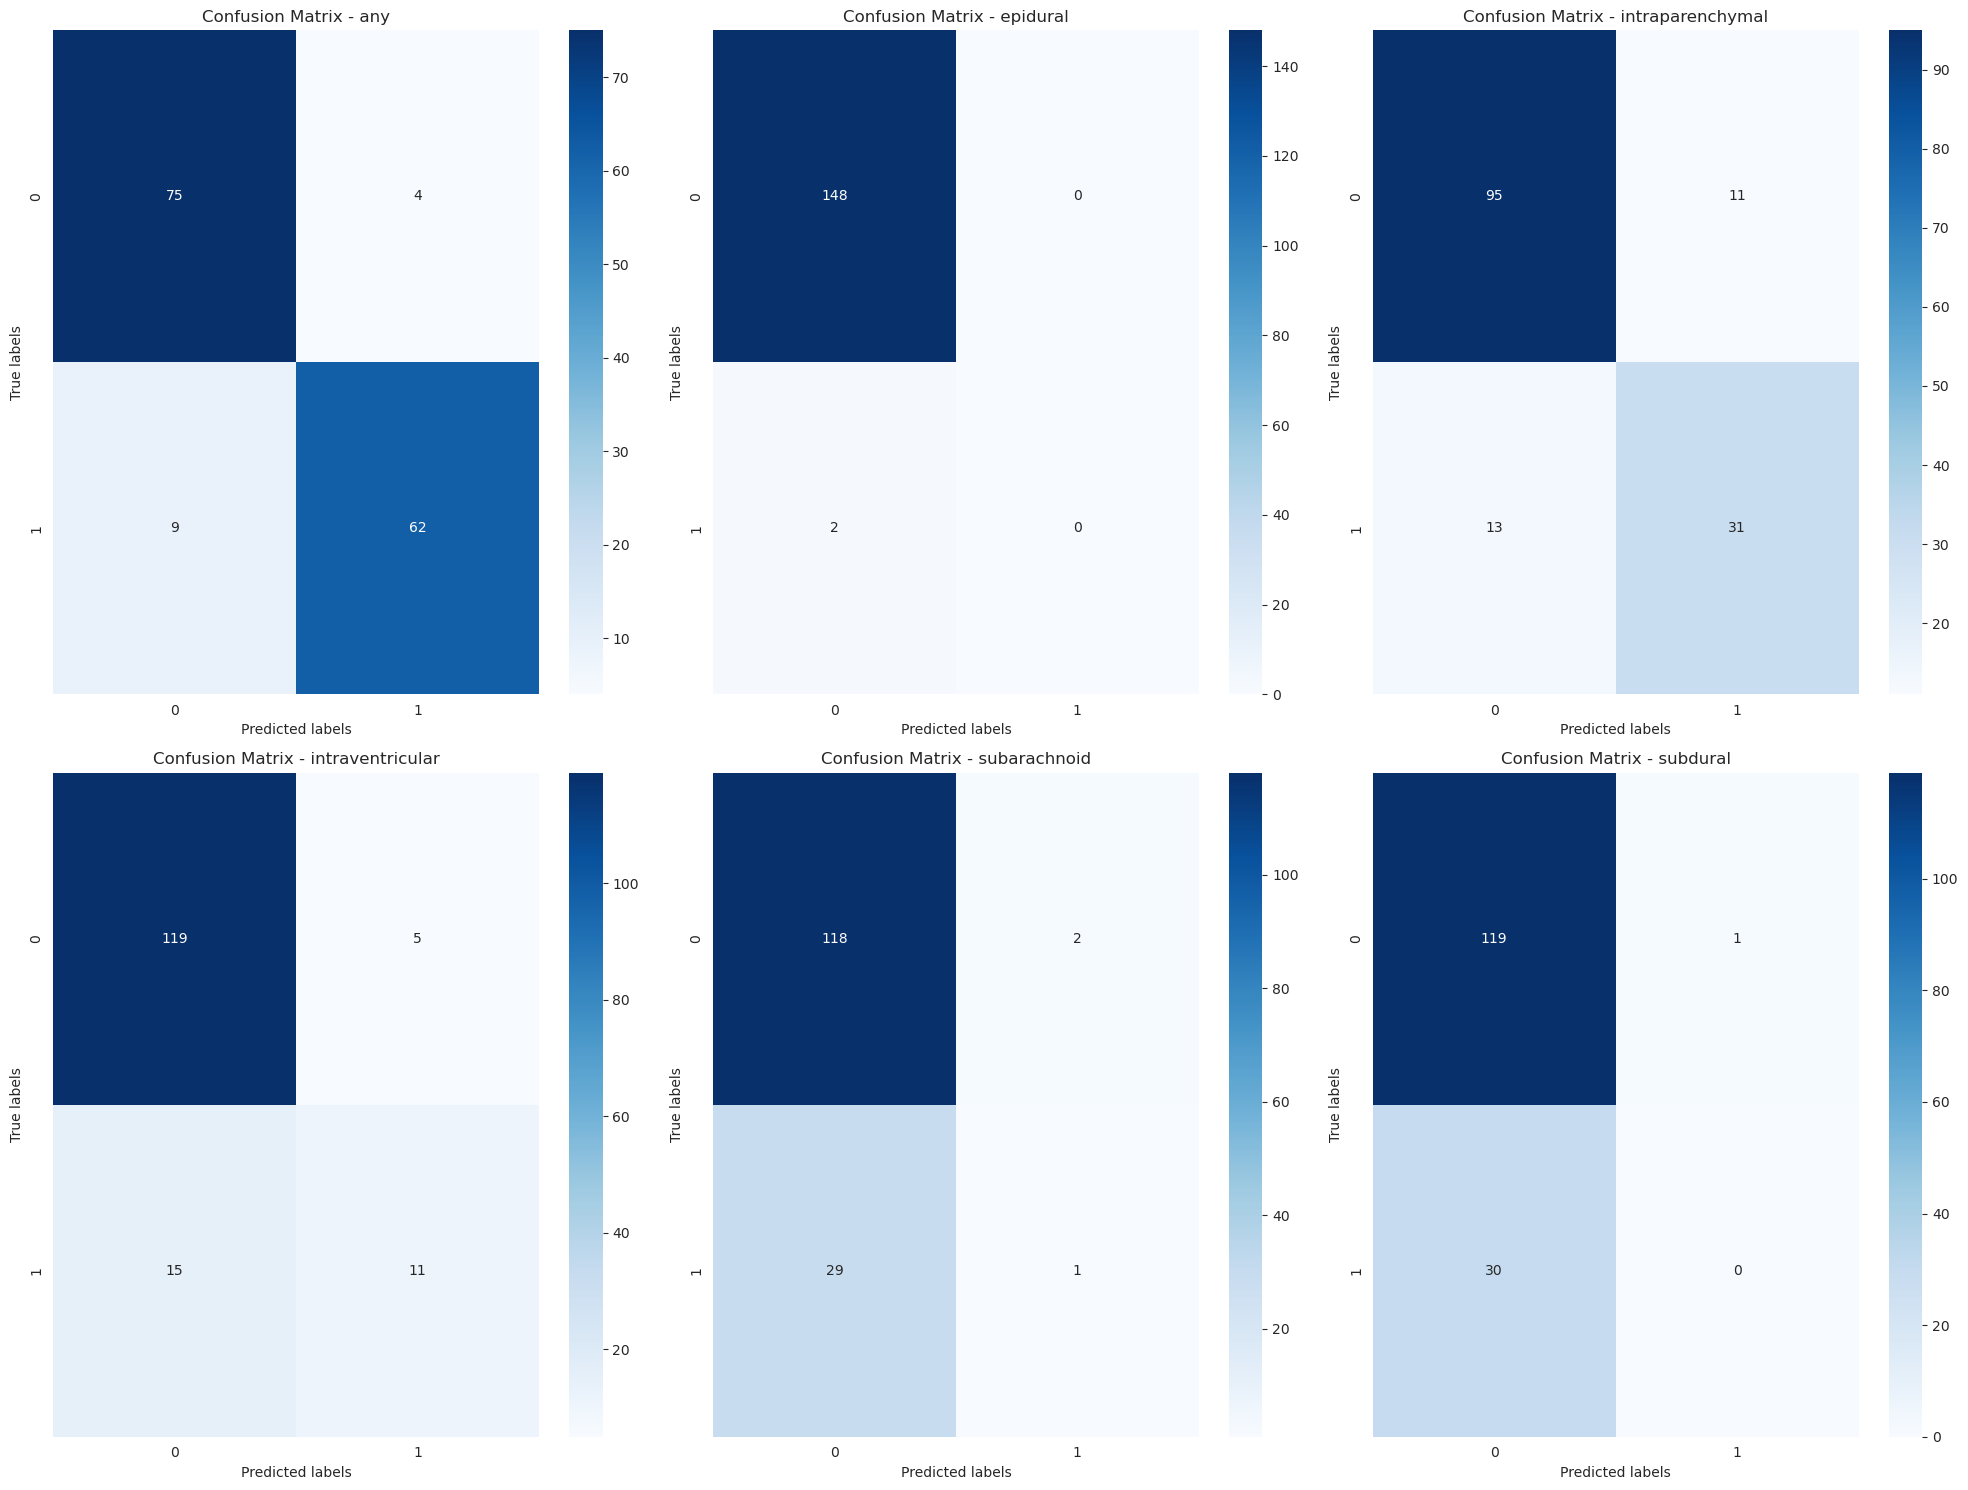

shape of multi_labels: torch.Size([750, 6])
shape of multi_labels: torch.Size([250, 6])
shape of multi_labels: torch.Size([150, 6])
Starting training...
Partial accuracy: 0.8291, Precision: 0.3753, Recall: 0.1665, F1: 0.2560
Precision (micro): 0.6171, Recall (micro): 0.3139, F1 (micro): 0.4161
Epoch 1/100: Train: Loss=0.6492, Acc=0.8291, Precision=0.6171, Recall=0.3139, F1=0.4161
Validation: Loss=0.5317, Acc=0.8540, Precision=0.8115, Recall=0.3356, F1=0.4748

Partial accuracy: 0.8360, Precision: 0.8411, Recall: 0.1396, F1: 0.3883
Precision (micro): 0.6839, Recall (micro): 0.2875, F1 (micro): 0.4048
Epoch 2/100: Train: Loss=0.3254, Acc=0.8360, Precision=0.6839, Recall=0.2875, F1=0.4048
Validation: Loss=0.4687, Acc=0.8567, Precision=0.8390, Recall=0.3356, F1=0.4794

Partial accuracy: 0.8360, Precision: 0.6650, Recall: 0.1496, F1: 0.7640
Precision (micro): 0.6650, Recall (micro): 0.3116, F1 (micro): 0.4243
Epoch 3/100: Train: Loss=0.1896, Acc=0.8360, Precision=0.6650, Recall=0.3116, F1=0.

KeyboardInterrupt: 

In [10]:
# Main function
def main(train_file, test_file, hidden_dim=64, learning_rate=0.00005, batch_size=16, num_epochs=100, num_instances=57):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    X_train, y_train, y_multi_train = load_data(train_file, num_instances=num_instances)
    # If test_file list includes 'cq500', then num_instance = 413
    if 'cq500' in test_file:
        num_instances_for_test = 32
        dataset = 'cq500'
    else:
        num_instances_for_test = num_instances
        dataset = 'rsna'
    X_test, y_test, y_multi_test = load_data(test_file, num_instances=num_instances_for_test, dataset=dataset)

    if NUM_CLASSES == 1:
        X_train, y_train, X_val, y_val, _, _ = split_data(X_train, y_multi_train, test_size=0.0, val_size=0.25, random_state=42)
    else:
        X_train, y_train, X_val, y_val, _, _ = split_dataset_for_multilabel(X_train, y_multi_train, test_size=0.0, val_size=0.25, random_state=42, num_classes=NUM_CLASSES)
    # Create Datasets and DataLoaders
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_multi_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, optimizer, and loss function
    feature_dim = X_train.shape[2]  # which is 8
    output_dim = 1

    model = CNN_Att(feature_dim, hidden_dim, output_dim, X_train, y_train).to(device)
    likelihood = nn.ModuleList([PGLikelihood().to(device) for _ in range(NUM_CLASSES)])

    mlls = nn.ModuleList([gpytorch.mlls.VariationalELBO(likelihood[i], model.gp_layer[i], num_data=len(train_loader)) for i in range(NUM_CLASSES)])
    mlls = [mll.to(device) for mll in mlls]
    variational_ngd_optim = [gpytorch.optim.NGD(model.gp_layer[i].variational_parameters(), num_data=len(train_loader), lr=0.01) for i in range(NUM_CLASSES)]

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    if NUM_CLASSES == 1:
        pos_weights = torch.tensor([2.0], dtype=torch.float32).to(device)
    else:
        pos_weights = torch.tensor([5.0] * NUM_CLASSES, dtype=torch.float32).to(device)
        # pos_weights = torch.tensor([5.0, 50.0, 10.0, 5.0, 5.0, 5.0], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Binary cross-entropy loss with logits

    # Training loop
    best_acc = 0
    best_model = None
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc,  train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device, likelihood, variational_ngd_optim, mlls)
        val_loss, val_acc, val_precision, val_recall, val_f1, val_co_kappa, val_labels, val_scores = evaluate(model, val_loader, criterion, device, likelihood, mlls)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}')
        print(f'Validation: Loss={val_loss:.4f}, Acc={val_acc:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}\n')
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()

    print(f'Best val accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model)

    # Plot ROC AUC curve
    test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls)
    print(f'Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}, Cohen Kappa={test_co_kappa:.4f}')
    if NUM_CLASSES == 1:
        test_auc = plot_roc_auc(test_labels, test_scores)
        test_auc_pr = plot_pr_curve(test_labels, test_scores)
        plot_confusion_matrix(test_labels, test_scores)
    else:
        class_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        test_labels = np.array(test_labels)
        test_scores = np.array(test_scores)
        plot_roc_auc_multilabel(test_labels, test_scores, class_names)
        plot_pr_curve_multilabel(test_labels, test_scores, class_names)
        test_preds = (test_scores >= threshold).astype(int)
        plot_confusion_matrix_multilabel(test_labels, test_preds, class_names)
        test_auc = 0
        test_auc_pr = 0

    return test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_auc, test_auc_pr

if __name__ == "__main__":
    def seed_everything(seed=42):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    NUM_CLASSES = 6
    seed_everything()

    # train_file = 'train_features.csv'
    # test_file = 'test_features.csv'
    # train_files = ['rsna_train_0_update.csv', 'rsna_train_1_update.csv', 'rsna_train_2_update.csv', 'rsna_train_3_update.csv', 'rsna_train_4_update.csv']
    # test_files = ['rsna_test_0_update.csv', 'rsna_test_1_update.csv', 'rsna_test_2_update.csv', 'rsna_test_3_update.csv', 'rsna_test_4_update.csv']
    train_files = ['rsna_train_0_redundancy.csv', 'rsna_train_1_redundancy.csv', 'rsna_train_2_redundancy.csv', 'rsna_train_3_redundancy.csv', 'rsna_train_4_redundancy.csv']
    test_files = ['rsna_test_0_redundancy.csv', 'rsna_test_1_redundancy.csv', 'rsna_test_2_redundancy.csv', 'rsna_test_3_redundancy.csv', 'rsna_test_4_redundancy.csv']
    # test_files = ['cq500_test_0_update.csv', 'cq500_test_1_update.csv', 'cq500_test_2_update.csv', 'cq500_test_3_update.csv', 'cq500_test_4_update.csv']
    # test_files = ['cq500_test_0_redundancy.csv', 'cq500_test_1_redundancy.csv', 'cq500_test_2_redundancy.csv', 'cq500_test_3_redundancy.csv', 'cq500_test_4_redundancy.csv']
    all_results = []
    for (train_file, test_file) in zip(train_files, test_files):
        train_file = f'author_data/{train_file}'
        test_file = f'author_data/{test_file}'
        test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_auc, test_auc_pr = main(train_file, test_file, num_instances=28, learning_rate=0.00005, batch_size=16, num_epochs=100)
        all_results.append([test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_auc, test_auc_pr])

    # Convert results to numpy array for easy calculation
    all_results = np.array(all_results)

    # Calculate mean and std for each metric
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)

    # Print results
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Cohen Kappa', 'ROC-AUC', 'AUC-PR']
    for i, metric in enumerate(metrics):
        print(f'{metric}: Mean = {mean_results[i]:.4f}, Std = {std_results[i]:.4f}')

# Visualization